In [1]:
import osmnx as ox
import folium
import networkx as nx
import geopandas as gpd
import warnings
from shapely.geometry import Point
import utm  # For UTM zone calculation
import matplotlib.pyplot as plt

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.")

In [2]:
# Define OSM tags
tags = {"building": True}
tag3 = {
    "amenity": ["hospital", "clinic", "doctors", "dentist", "pharmacy", "veterinary", "healthcare"],
    "healthcare": True,
    "building": ["hospital", "clinic", "medical"],
    "emergency": "yes",
    "office": "doctor",
    "shop": "medical_supply"
}

In [3]:
# Define study area
center_point = (7.34697, 5.10993)
search_radius = 2000  # 2 km

In [4]:
# Fetch OSM data
building = ox.features_from_point(center_point, tags=tags, dist=search_radius)
hospitals = ox.features_from_point(center_point, tags=tag3, dist=search_radius)
road_network = ox.graph_from_point(center_point, network_type="walk", dist=search_radius)

In [5]:
# Convert road network to GeoDataFrame (for visualization)
road_network_ = ox.graph_to_gdfs(road_network, nodes=False, edges=True)

In [6]:
# Calculate UTM CRS based on the center point
utm_zone = utm.from_latlon(center_point[0], center_point[1])
utm_crs = f"+proj=utm +zone={utm_zone[2]} +{'south' if utm_zone[3] else ''} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

In [7]:
# Reproject geometries to UTM CRS for accurate distance calculations
building = building.to_crs(utm_crs)
hospitals = hospitals.to_crs(utm_crs)
road_network_ = road_network_.to_crs(utm_crs)

In [8]:
# Create Folium Map
map_center = [
    building.geometry.centroid.y.mean(),
    building.geometry.centroid.x.mean(),
]
m = folium.Map(location=center_point, zoom_start=16)

# Add buildings layer
folium.GeoJson(
    building.to_crs(epsg=4326),  # Convert back to WGS84 for visualization
    name="Buildings",
    tooltip=folium.features.GeoJsonTooltip(fields=["building"], labels=True),
    style_function=lambda x: {"color": "blue", "fillColor": "blue", "weight": 1, "opacity": 0.6},
).add_to(m)

# Add hospitals layer
folium.GeoJson(
    hospitals.to_crs(epsg=4326),  # Convert back to WGS84 for visualization
    name="Hospitals",
    tooltip=folium.features.GeoJsonTooltip(fields=["healthcare"], labels=True),
    style_function=lambda x: {"color": "red", "fillColor": "orange", "fillOpacity": 0.6, "weight": 1},
).add_to(m)

# Add road network layer
folium.GeoJson(
    road_network_.to_crs(epsg=4326),  # Convert back to WGS84 for visualization
    name="Road Network",
    style_function=lambda x: {"color": "grey", "weight": 2, "opacity": 0.7},
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

In [9]:
# Corrected Nearest Hospital Node Extraction
hospital_nodes = [
    ox.distance.nearest_nodes(road_network, x, y) for x, y in zip(hospitals.geometry.centroid.x, hospitals.geometry.centroid.y)
]

# Function to compute shortest path distance to nearest hospital
def get_nearest_hospital_distance(building):
    try:
        # Get nearest road network node to the building
        nearest_node = ox.distance.nearest_nodes(road_network, building.centroid.x, building.centroid.y)

        # Compute shortest distance to any hospital
        return min(nx.shortest_path_length(road_network, nearest_node, hn, weight="length") for hn in hospital_nodes)
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None  # Handle errors

# Compute distances for all buildings
building["hospital_distance"] = building.geometry.apply(get_nearest_hospital_distance)

# Display the updated building GeoDataFrame with distances
print(building[["building", "hospital_distance"]].head())

                        building  hospital_distance
element id                                         
node    10006129322  Unspecified           0.000000
way     570032498            yes        3274.024937
        570032499            yes        3274.024937
        570032500            yes        3274.024937
        570032501            yes        3274.024937


C:\Users\173330\AppData\Local\Temp\ipykernel_25984\2662883239.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


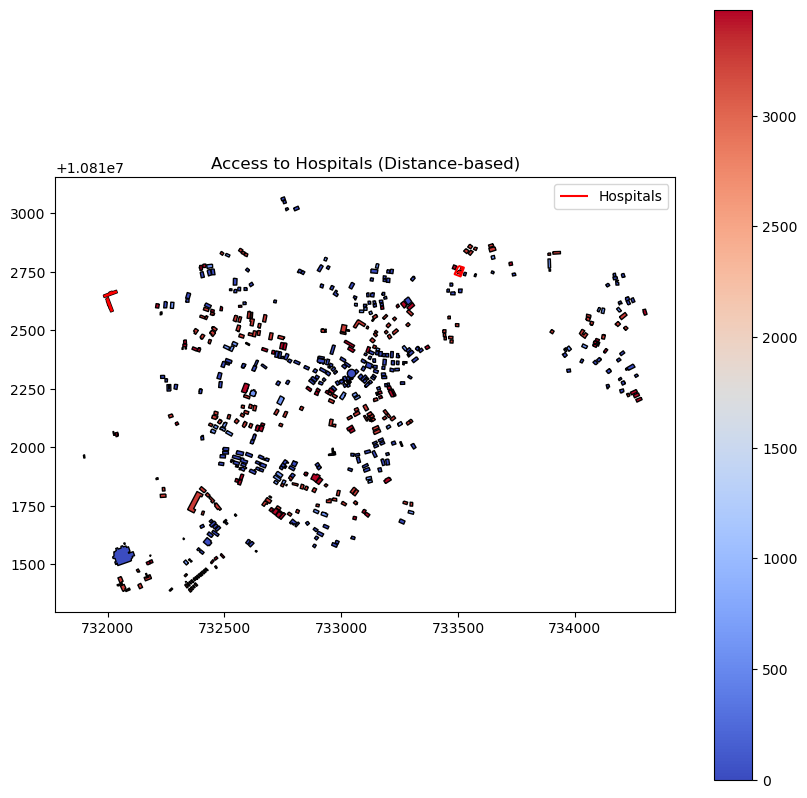

In [10]:
# Plotting the buildings with distances to hospitals
fig, ax = plt.subplots(figsize=(10, 10))
building.plot(ax=ax, column="hospital_distance", cmap="coolwarm", legend=True, edgecolor="black")
hospitals.plot(ax=ax, color="red", markersize=50, label="Hospitals")
plt.title("Access to Hospitals (Distance-based)")
plt.legend()
plt.show()

In [14]:

# Load population data (WorldPop, OpenStreetMap or other sources)
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Example: Load population raster dataset (Assuming it's available)
# Change path to actual population dataset if available
population_raster = "C:/Users/173330/Downloads/GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R9_C19/GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R9_C19.tif"

try:
    with rasterio.open(population_raster) as src:
        population_data = src.read(1)
        population_bounds = src.bounds

    print("Population data loaded successfully.")
except Exception as e:
    print("Error loading population data:", e)


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\173330\AppData\Local\Temp\ipykernel_25984\2304489795.py:8: SyntaxWarning: invalid escape sequence '\D'
  population_raster = "C:/Users/173330\Downloads/GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R9_C19/GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R9_C19.tif"


Population data loaded successfully.


In [17]:
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra

def compute_isochrone(graph, center_node, time_limit=600):  # 10 min walk (~600 seconds)
    try:
        distances, _ = single_source_dijkstra(graph, center_node, weight="length")
        isochrone_nodes = {node for node, time in distances.items() if time <= time_limit}
        return isochrone_nodes
    except Exception as e:
        print(f"Error computing isochrone: {e}")
        return set()

# Calculate service areas for each hospital
hospital_service_areas = {}
for hospital_node in hospital_nodes:
    hospital_service_areas[hospital_node] = compute_isochrone(road_network, hospital_node, time_limit=900)

print("Service areas computed for hospitals.")


Service areas computed for hospitals.


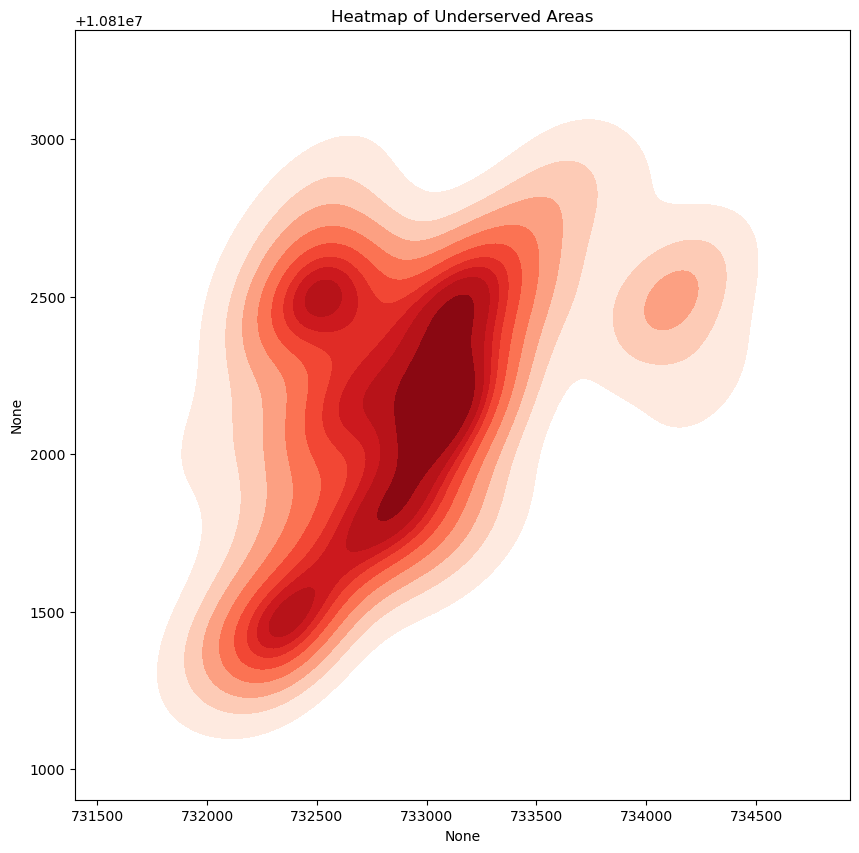

In [20]:
import seaborn as sns

# Convert buildings to centroids for point representation (for heatmap) and filter underserved buildings
# Assuming 1500 meters is the maximum acceptable distance to a hospital
# You can adjust this threshold based on local conditions and accessibility standards
# underserved_buildings = un_build
un_build = building[building["hospital_distance"] > 1500].copy()
un_build["centroid"] = un_build.geometry.centroid

# Extract x and y coordinates
x_coords = un_build["centroid"].x
y_coords = un_build["centroid"].y

# Create a density heatmap of underserved regions
fig, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(x=x_coords, y=y_coords, cmap="Reds", fill=True, ax=ax)
plt.title("Heatmap of Underserved Areas")
plt.show()